In [13]:
import os
import torch
import csv
import pandas as pd
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

In [2]:
gdx = "/kaggle/input/baggage-xray-threats/Augmented_Dataset/GDXray/images"
pid = "/kaggle/input/baggage-xray-threats/Augmented_Dataset/PIDRAY/images"
six = "/kaggle/input/baggage-xray-threats/Augmented_Dataset/Sixray/images"

batch_size = 64
learning_rate = 1e-3
epochs = 30
img_size = 128
latent_dim = 128
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint_path = "vae_checkpoint.pth"

print(device)

cuda


In [3]:
# custom dataset
class UnlabeledImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(dp, f)
            for dp, dn, filenames in os.walk(root_dir)
            for f in filenames if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image
        except Exception:
            return self.__getitem__((idx + 1) % len(self))

# Transform
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

# Combine datasets
datasets_list = []
for path in [gdx, pid, six]:
    if os.path.exists(path):
        ds = UnlabeledImageDataset(path, transform)
        print(f"Loaded {len(ds)} images from: {path}")
        datasets_list.append(ds)
    else:
        print(f"Path not found: {path}")

if len(datasets_list) == 0:
    raise RuntimeError("No valid datasets found!")

combined_dataset = ConcatDataset(datasets_list)
train_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
print(f"Total images in combined dataset: {len(combined_dataset)}")

Loaded 11032 images from: /kaggle/input/baggage-xray-threats/Augmented_Dataset/GDXray/images
Loaded 16008 images from: /kaggle/input/baggage-xray-threats/Augmented_Dataset/PIDRAY/images
Loaded 59486 images from: /kaggle/input/baggage-xray-threats/Augmented_Dataset/Sixray/images
Total images in combined dataset: 86526


In [4]:
# model: variational autoencoder
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.ReLU(True)
        )

        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 256 * 8 * 8)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 256, 8, 8)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [ ]:
# training setup
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss(reduction='sum')

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = criterion(recon_x, x)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

start_epoch = 0

# load checkpoint if exists
if os.path.exists(checkpoint_path):
    print("Loading checkpoint.")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resumed from epoch {start_epoch}")

In [6]:
log_file = "training_log.csv"
with open(log_file, mode="w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch", "train_loss", "val_loss"])

In [7]:
# training loop
for epoch in range(start_epoch, epochs):
    model.train()
    running_loss = 0.0

    for imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        imgs = imgs.to(device)
        optimizer.zero_grad()

        recon, mu, logvar = model(imgs)
        loss = vae_loss(recon, imgs, mu, logvar)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader.dataset)

    # log training loss to CSV
    with open(log_file, mode="a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch + 1, avg_loss, None])

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

    torch.save({
        "epoch": epoch + 1,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict()
    }, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch+1}")


Epoch 1/30: 100%|██████████| 1352/1352 [13:29<00:00,  1.67it/s]


Epoch [1/30] Loss: 1019.6755
Checkpoint saved at epoch 1


Epoch 2/30: 100%|██████████| 1352/1352 [09:28<00:00,  2.38it/s]


Epoch [2/30] Loss: 641.9074
Checkpoint saved at epoch 2


Epoch 3/30: 100%|██████████| 1352/1352 [09:33<00:00,  2.36it/s]


Epoch [3/30] Loss: 594.4000
Checkpoint saved at epoch 3


Epoch 4/30: 100%|██████████| 1352/1352 [09:50<00:00,  2.29it/s]


Epoch [4/30] Loss: 577.5430
Checkpoint saved at epoch 4


Epoch 5/30: 100%|██████████| 1352/1352 [09:39<00:00,  2.33it/s]


Epoch [5/30] Loss: 560.7737
Checkpoint saved at epoch 5


Epoch 6/30: 100%|██████████| 1352/1352 [09:54<00:00,  2.27it/s]


Epoch [6/30] Loss: 548.2674
Checkpoint saved at epoch 6


Epoch 7/30: 100%|██████████| 1352/1352 [09:43<00:00,  2.32it/s]


Epoch [7/30] Loss: 539.4656
Checkpoint saved at epoch 7


Epoch 8/30: 100%|██████████| 1352/1352 [09:53<00:00,  2.28it/s]


Epoch [8/30] Loss: 547.1082
Checkpoint saved at epoch 8


Epoch 9/30: 100%|██████████| 1352/1352 [09:49<00:00,  2.29it/s]


Epoch [9/30] Loss: 537.4036
Checkpoint saved at epoch 9


Epoch 10/30: 100%|██████████| 1352/1352 [09:30<00:00,  2.37it/s]


Epoch [10/30] Loss: 524.0021
Checkpoint saved at epoch 10


Epoch 11/30: 100%|██████████| 1352/1352 [09:40<00:00,  2.33it/s]


Epoch [11/30] Loss: 520.2659
Checkpoint saved at epoch 11


Epoch 12/30: 100%|██████████| 1352/1352 [09:28<00:00,  2.38it/s]


Epoch [12/30] Loss: 516.2525
Checkpoint saved at epoch 12


Epoch 13/30: 100%|██████████| 1352/1352 [09:50<00:00,  2.29it/s]


Epoch [13/30] Loss: 514.9366
Checkpoint saved at epoch 13


Epoch 14/30: 100%|██████████| 1352/1352 [09:43<00:00,  2.32it/s]


Epoch [14/30] Loss: 509.7712
Checkpoint saved at epoch 14


Epoch 15/30: 100%|██████████| 1352/1352 [09:24<00:00,  2.40it/s]


Epoch [15/30] Loss: 507.6429
Checkpoint saved at epoch 15


Epoch 16/30: 100%|██████████| 1352/1352 [09:37<00:00,  2.34it/s]


Epoch [16/30] Loss: 504.9152
Checkpoint saved at epoch 16


Epoch 17/30: 100%|██████████| 1352/1352 [09:29<00:00,  2.37it/s]


Epoch [17/30] Loss: 502.6438
Checkpoint saved at epoch 17


Epoch 18/30: 100%|██████████| 1352/1352 [09:37<00:00,  2.34it/s]


Epoch [18/30] Loss: 500.9641
Checkpoint saved at epoch 18


Epoch 19/30: 100%|██████████| 1352/1352 [09:49<00:00,  2.29it/s]


Epoch [19/30] Loss: 498.7408
Checkpoint saved at epoch 19


Epoch 20/30: 100%|██████████| 1352/1352 [10:04<00:00,  2.24it/s]


Epoch [20/30] Loss: 497.0521
Checkpoint saved at epoch 20


Epoch 21/30: 100%|██████████| 1352/1352 [09:54<00:00,  2.27it/s]


Epoch [21/30] Loss: 495.5880
Checkpoint saved at epoch 21


Epoch 22/30: 100%|██████████| 1352/1352 [09:54<00:00,  2.27it/s]


Epoch [22/30] Loss: 493.7971
Checkpoint saved at epoch 22


Epoch 23/30: 100%|██████████| 1352/1352 [09:45<00:00,  2.31it/s]


Epoch [23/30] Loss: 492.8255
Checkpoint saved at epoch 23


Epoch 24/30: 100%|██████████| 1352/1352 [09:29<00:00,  2.38it/s]


Epoch [24/30] Loss: 491.3879
Checkpoint saved at epoch 24


Epoch 25/30: 100%|██████████| 1352/1352 [09:27<00:00,  2.38it/s]


Epoch [25/30] Loss: 490.5712
Checkpoint saved at epoch 25


Epoch 26/30: 100%|██████████| 1352/1352 [09:52<00:00,  2.28it/s]


Epoch [26/30] Loss: 489.1938
Checkpoint saved at epoch 26


Epoch 27/30: 100%|██████████| 1352/1352 [10:25<00:00,  2.16it/s]


Epoch [27/30] Loss: 488.2929
Checkpoint saved at epoch 27


Epoch 28/30: 100%|██████████| 1352/1352 [11:49<00:00,  1.91it/s]


Epoch [28/30] Loss: 486.8999
Checkpoint saved at epoch 28


Epoch 29/30: 100%|██████████| 1352/1352 [11:35<00:00,  1.94it/s]


Epoch [29/30] Loss: 486.0789
Checkpoint saved at epoch 29


Epoch 30/30: 100%|██████████| 1352/1352 [12:32<00:00,  1.80it/s]


Epoch [30/30] Loss: 485.3285
Checkpoint saved at epoch 30


In [24]:
model.eval()
total_recon_loss = 0.0
total_kl = 0.0

with torch.no_grad():
    for imgs in train_loader:
        imgs = imgs.to(device, non_blocking=True)
        recon, mu, logvar = model(imgs)

        # use mean instead of sum for better scaling
        recon_loss = nn.functional.mse_loss(recon, imgs, reduction='mean')
        kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        total_recon_loss += recon_loss.item()
        total_kl += kl_div.item()

num_batches = len(train_loader)
avg_recon_loss = total_recon_loss / num_batches
avg_kl = total_kl / num_batches

print(f"Average Reconstruction Loss: {avg_recon_loss:.4f}")
print(f"Average KL Divergence: {avg_kl:.4f}")

Average Reconstruction Loss: 0.0070
Average KL Divergence: 1.0550


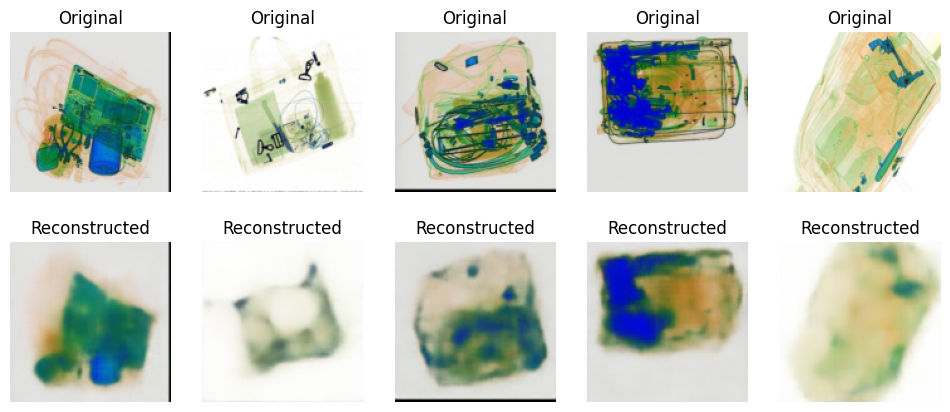

In [23]:
imgs = next(iter(train_loader))
imgs = imgs.to(device)

model.eval()
with torch.no_grad():  # safer, disables grad tracking globally
    recon, _, _ = model(imgs)

plt.figure(figsize=(12, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i].cpu().permute(1, 2, 0))
    plt.axis("off")
    plt.title("Original")

    plt.subplot(2, 5, i + 6)
    plt.imshow(recon[i].detach().cpu().permute(1, 2, 0))  # <-- detach() fixes it
    plt.axis("off")
    plt.title("Reconstructed")
plt.show()

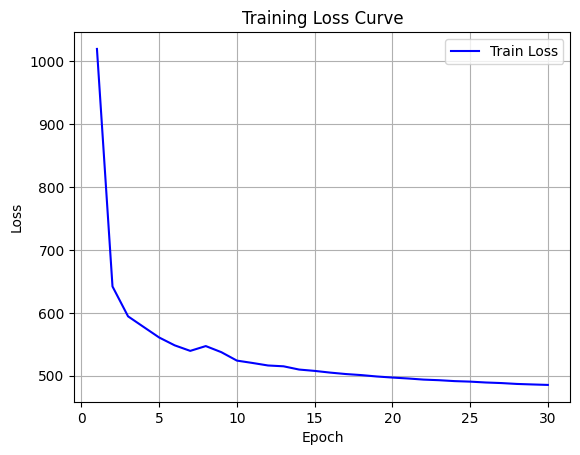

In [14]:
df = pd.read_csv("training_log.csv")

plt.plot(df["epoch"], df["train_loss"], label="Train Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# save the model
torch.save(model.state_dict(), "vae_final.pt")
print("Final model saved.")

Final model saved.


In [27]:
np.save("vae_latents.npy", latents)
print("Saved latent vectors to vae_latents.npy")

Saved latent vectors to vae_latents.npy
